In [2]:
import pandas as pd
import sys
import os
import json
from datetime import datetime

# Add src to path to import local modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import your custom modules
from utils import ResourceTracker, set_global_seed, ExperimentLogger
from nlp_models import (
    load_zero_shot_pipeline, 
    extract_context_sentences, 
    classify_sentences_batch, 
    get_hf_model_metadata,
    get_accompanying_terms
)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from ast import literal_eval

# Initialize Logging and Seeding
logger = ExperimentLogger(log_dir="../reports")
set_global_seed(42)

Logging experiments to: ../reports/experiment_20260113_200732.json
Global seed set to: 42


# 1. Finding top countries

In [2]:
# Finding top countries
df = pd.read_csv("../data/processed/putins_talks_with_countries.csv")
all_countries = df['extracted_countries'].apply(literal_eval).explode().dropna()
country_counts = all_countries[all_countries != 'Russia'].value_counts()
country_counts

extracted_countries
Ukraine           3838
China             2964
Syria             2384
United States     1646
Turkey            1468
                  ... 
Greenland            1
Virgin Islands       1
Seychelles           1
Samoa                1
Bhutan               1
Name: count, Length: 170, dtype: int64

In [3]:
country_counts.to_csv("../data/processed/country_counts.csv")

In [4]:
top_countries = country_counts.head(5).index.tolist()
top_countries

['Ukraine', 'China', 'Syria', 'United States', 'Turkey']

# 2. Extracting sentences mentioning chosen countries

In [4]:
# Create target terms
target_terms = {
    'Poland': ['Poland', 'Polish', 'Poles'],
    'Ukraine': ['Ukraine', 'Ukrainian', 'Ukrainians'],
    'United States': ['United States', 'USA', 'American', 'Americans', 'U.S.'],
    'China': ['China', 'Chinese'],
    'Syria': ['Syria', 'Syrian'],
    'Russia': ['Russia', 'Russian', 'Russians', 'Soviets', 'Soviet Union', 'USSR', 'Soviet', 'Russian Federation']
}

In [8]:
top_countries.append('Poland')
for key, terms in target_terms.items():
    print(f"Processing country: {key}")
    # Extract context sentences
    with ResourceTracker("Sentence Extraction") as rt:
        extracted_data = extract_context_sentences(
            texts=df['transcript_filtered'].tolist(), 
            dates=df['date'].tolist(),
            target_terms=terms,
            spacy_model_name="en_core_web_sm"
        )
    logger.log_operation("Sentence_Extraction", rt.duration, rt.peak_memory_mb, {"count": len(extracted_data)})
    df_sentences = pd.DataFrame(extracted_data)
    print(f"Found {len(df_sentences)} relevant sentences.")
    df_sentences.to_csv(f"../data/sentences/sentences_{key}.csv", index=False)
    df_sentences.head()

Processing country: Poland
[Sentence Extraction] Finished.
   Duration: 258.9408 seconds
   Peak Memory: 527.33 MB
Found 361 relevant sentences.
Processing country: Ukraine
[Sentence Extraction] Finished.
   Duration: 255.7312 seconds
   Peak Memory: 525.70 MB
Found 3488 relevant sentences.
Processing country: United States
[Sentence Extraction] Finished.
   Duration: 255.0165 seconds
   Peak Memory: 525.84 MB
Found 3478 relevant sentences.
Processing country: China
[Sentence Extraction] Finished.
   Duration: 255.6271 seconds
   Peak Memory: 525.72 MB
Found 2721 relevant sentences.
Processing country: Syria
[Sentence Extraction] Finished.
   Duration: 253.4403 seconds
   Peak Memory: 536.38 MB
Found 2213 relevant sentences.
Processing country: Russia
[Sentence Extraction] Finished.
   Duration: 254.2516 seconds
   Peak Memory: 526.76 MB
Found 32359 relevant sentences.


# 3. Finding accompanying terms

In [6]:
for key, terms in target_terms.items():
    print(f"Processing country: {key}")
    df_sentences = pd.read_csv(f"../data/sentences/sentences_{key}.csv")
    all_accompanying_terms = []
    for sentence in df_sentences['sentence']:
        accompanying_terms = get_accompanying_terms(
            sentence, 
            terms
        )
        all_accompanying_terms.append(accompanying_terms)
    df_sentences['accompanying_terms'] = all_accompanying_terms
    df_sentences.to_csv(f"../data/sentences/sentences_{key}_with_terms.csv", index=False)

Processing country: Poland
Processing country: Ukraine
Processing country: United States
Processing country: China
Processing country: Syria
Processing country: Russia


In [25]:
# Create a dataframe summary of accompanying terms
countries_with_terms = {}
for key, terms in target_terms.items():
    print(f"Processing country: {key}")
    df_sentences = pd.read_csv(f"../data/sentences/sentences_{key}_with_terms.csv")
    # make a list of all accompanying terms with duplicates
    all_terms = []
    for term_list in df_sentences['accompanying_terms']:
        if isinstance(term_list, str):
            term_list_eval = literal_eval(term_list)
            all_terms.extend(term_list_eval)
    countries_with_terms[key] = all_terms

# Save country as one clumn and accompanying terms as another column
rows = []
for country, terms in countries_with_terms.items():
    rows.append({'country': country, 'accompanying_terms': terms})    
df_accompanying_terms = pd.DataFrame(rows)
df_accompanying_terms.to_csv("../data/processed/country_accompanying_terms.csv", index=False)

Processing country: Poland
Processing country: Ukraine
Processing country: United States
Processing country: China
Processing country: Syria
Processing country: Russia


# 4. Classifying sentences using zero-shot classification

In [7]:
# Configuration
LABELS_BASE = ["partner", "enemy", "neutral"]
LABELS_SYNONYMS = ["ally", "adversary", "unbiased"]

# Load Model
model_name = "facebook/bart-large-mnli"
print(f"Loading model: {model_name}...")
zs_pipeline = load_zero_shot_pipeline(model_name)

# Log Model Metadata for Report
meta = get_hf_model_metadata(zs_pipeline)
print(f"Model Architecture: {meta['model_architecture']}")
print(f"Commit Hash: {meta['commit_hash']}")

Loading model: facebook/bart-large-mnli...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model Architecture: BartForSequenceClassification
Commit Hash: d7645e127eaf1aefc7862fd59a17a5aa8558b8ce


In [12]:
for key, terms in target_terms.items():
    print(f"Classifying sentences for country: {key}")
    df_sentences = pd.read_csv(f"../data/sentences/sentences_{key}_with_terms.csv")
    
    if key == 'Russia':
        LABELS_BASE = ["victim", "leader", "defender"]
        LABELS_SYNONYMS = ["casualty", "commander", "protector"]
    
    # Classify sentences in batches
    print("Running Zero-Shot (Base Labels)...")
    with ResourceTracker("ZeroShot_BaseLabels") as rt:
        results_base = classify_sentences_batch(
            zs_pipeline, 
            df_sentences['sentence'].tolist(), 
            LABELS_BASE
        )
    
    logger.log_operation(
        name="ZeroShot_Base",
        duration=rt.duration,
        memory_mb=rt.peak_memory_mb,
        metrics={"model": model_name, "labels": LABELS_BASE, "hash": meta['commit_hash']}
    )
    
    df_sentences['zs_base_label'] = [r['top_label'] for r in results_base]
    df_sentences['zs_base_score'] = [r['top_score'] for r in results_base]
    
    print("Running Zero-Shot (Synonym Labels)...")
    with ResourceTracker("ZeroShot_SynonymLabels") as rt:
        results_syn = classify_sentences_batch(
            zs_pipeline, 
            df_sentences['sentence'].tolist(), 
            LABELS_SYNONYMS)
    
    logger.log_operation(
        name="ZeroShot_Synonyms",
        duration=rt.duration,
        memory_mb=rt.peak_memory_mb,
        metrics={"model": model_name, "labels": LABELS_SYNONYMS}
    )
    
    df_sentences['zs_syn_label'] = [r['top_label'] for r in results_syn]
    df_sentences['zs_syn_score'] = [r['top_score'] for r in results_syn]
    
    # Save classified results
    df_sentences.to_csv(f"../data/sentences/sentences_{key}_classified.csv", index=False)
    print(f"Saved classified sentences for {key}.")

Classifying sentences for country: Poland
Running Zero-Shot (Base Labels)...
[ZeroShot_BaseLabels] Finished.
   Duration: 45.8916 seconds
   Peak Memory: 0.77 MB
Running Zero-Shot (Synonym Labels)...
[ZeroShot_SynonymLabels] Finished.
   Duration: 45.2267 seconds
   Peak Memory: 0.35 MB
Saved classified sentences for Poland.
Classifying sentences for country: Ukraine
Running Zero-Shot (Base Labels)...
[ZeroShot_BaseLabels] Finished.
   Duration: 415.3089 seconds
   Peak Memory: 3.53 MB
Running Zero-Shot (Synonym Labels)...
[ZeroShot_SynonymLabels] Finished.
   Duration: 414.4275 seconds
   Peak Memory: 3.36 MB
Saved classified sentences for Ukraine.
Classifying sentences for country: United States
Running Zero-Shot (Base Labels)...
[ZeroShot_BaseLabels] Finished.
   Duration: 412.3324 seconds
   Peak Memory: 3.49 MB
Running Zero-Shot (Synonym Labels)...
[ZeroShot_SynonymLabels] Finished.
   Duration: 412.1403 seconds
   Peak Memory: 3.35 MB
Saved classified sentences for United States.

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[ZeroShot_BaseLabels] Finished.
   Duration: 263.4440 seconds
   Peak Memory: 2.21 MB
Running Zero-Shot (Synonym Labels)...
[ZeroShot_SynonymLabels] Finished.
   Duration: 263.1236 seconds
   Peak Memory: 2.14 MB
Saved classified sentences for Syria.
Classifying sentences for country: Russia
Running Zero-Shot (Base Labels)...
[ZeroShot_BaseLabels] Finished.
   Duration: 3792.1597 seconds
   Peak Memory: 33.50 MB
Running Zero-Shot (Synonym Labels)...
[ZeroShot_SynonymLabels] Finished.
   Duration: 3792.4268 seconds
   Peak Memory: 31.09 MB
Saved classified sentences for Russia.


# 5. Classifying sentences using Gemini and human annotation

In [4]:
# Export random 20 sentences for every country
for key, terms in target_terms.items():
    print(f"Processing country: {key}")
    df_sentences = pd.read_csv(f"../data/sentences/sentences_{key}_classified.csv")
    df_sample = df_sentences.sample(n=20, random_state=42)
    df_sample.to_csv(f"../data/sentences/sentences_{key}_sample.csv", index=False)
    print(f"Exported sample for {key}.")

Processing country: Poland
Exported sample for Poland.
Processing country: Ukraine
Exported sample for Ukraine.
Processing country: United States
Exported sample for United States.
Processing country: China
Exported sample for China.
Processing country: Syria
Exported sample for Syria.
Processing country: Russia
Exported sample for Russia.


# 6. Classification evaluation

In [42]:
# Read the annotations and merge tables
df_all_sentences = []
for key, terms in target_terms.items():
    df_sentences = pd.read_csv(f"../data/sentences/sentences_{key}_sample_annotated.csv")
    
    print(f"Processing annotated sentences for country: {key}")
    # Map synonym labels back to base labels for comparison
    if key == 'Russia':
        LABELS_BASE = ["victim", "leader", "defender"]
        LABELS_SYNONYMS = ["casualty", "commander", "protector"]
    else:
        LABELS_BASE = ["partner", "enemy", "neutral"]
        LABELS_SYNONYMS = ["ally", "adversary", "unbiased"]
    synonym_to_base = dict(zip(LABELS_SYNONYMS, LABELS_BASE))
    df_sentences['zs_syn_label_mapped'] = df_sentences['zs_syn_label'].map(synonym_to_base)
    df_sentences['country'] = key
    
    df_all_sentences.append(df_sentences)
    
df_annotated = pd.concat(df_all_sentences, ignore_index=True)
print(f"Total sentences for evaluation: {len(df_sentences)}")

Processing annotated sentences for country: Poland
Processing annotated sentences for country: Ukraine
Processing annotated sentences for country: United States
Processing annotated sentences for country: China
Processing annotated sentences for country: Syria
Processing annotated sentences for country: Russia
Total sentences for evaluation: 20


In [43]:
df_annotated

,source_doc_id,date,sentence,found_term,accompanying_terms,zs_base_label,zs_base_score,zs_syn_label,zs_syn_score,gemini_classification_1,gemini_classification_2,manual_classification,zs_syn_label_mapped,country
0,3932,2019-12-20 17:00:00,The fact that Poland expressed its appetite on...,poland,[],partner,0.702611,adversary,0.611747,enemy,enemy,enemy,enemy,Poland
1,1238,2014-11-05 16:10:00,"But what did Poland itself do, when the German...",poland,['itself'],enemy,0.684295,adversary,0.865852,enemy,enemy,enemy,enemy,Poland
2,910,2014-03-04 15:40:00,As we all know they were trained at special ba...,poland,[],partner,0.926949,ally,0.665182,enemy,enemy,neutral,partner,Poland
3,4740,2022-02-21 22:35:00,"In the process, he gave Poland part of what wa...",poland,[],partner,0.793566,adversary,0.692365,enemy,neutral,neutral,enemy,Poland
4,2004,2016-06-07 18:20:00,With regard to Poland not renewing the gas con...,poland,[],partner,0.935437,adversary,0.604857,partner,partner,enemy,enemy,Poland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,4842,2022-06-09 18:20:00,"When he founded the new capital, none of the E...",russia,[],leader,0.539921,protector,0.565666,victim,victim,victim,defender,Russia
116,2417,2017-03-29 21:20:00,I would like to remind you that this region ha...,russia,[],defender,0.567929,protector,0.829647,defender,leader,leader,defender,Russia
117,1215,2014-10-15 23:00:00,"The people of Crimea, seeing the complexity an...",russia,[],defender,0.680679,protector,0.867318,defender,defender,defender,defender,Russia
118,4643,2021-11-30 16:00:00,And we intend to continue doing this by addres...,russia,[],leader,0.477912,protector,0.594687,leader,leader,leader,defender,Russia


In [44]:
def calculate_metrics(predicted_label, true_label):
    """Calculates precision, recall, and F1 score for a single prediction."""
    if true_label == '':
        return 0.0, 0.0, 0.0  # No true label provided
    tp = int(predicted_label == true_label)
    fp = int(predicted_label != true_label)
    fn = int(predicted_label != true_label)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

In [45]:
# Calculate scores
llm_columns = ["zs_base_label", "zs_syn_label_mapped", "gemini_classification_1", "gemini_classification_2"]
metrics_rows = []
for col in llm_columns:
    if col not in df_annotated.columns:
        continue
    metrics = df_annotated.apply(lambda row: calculate_metrics(row[col], row.get('manual_classification', '')), axis=1)
    precision_mean = metrics.apply(lambda x: x[0]).mean()
    recall_mean = metrics.apply(lambda x: x[1]).mean()
    f1_mean = metrics.apply(lambda x: x[2]).mean()
    metrics_rows.append({'method': col, 'precision': precision_mean, 'recall': recall_mean, 'f1': f1_mean})

metrics_df = pd.DataFrame(metrics_rows, columns=['method', 'precision', 'recall', 'f1'])
print(metrics_df)

                    method  precision    recall        f1
0            zs_base_label   0.450000  0.450000  0.450000
1      zs_syn_label_mapped   0.441667  0.441667  0.441667
2  gemini_classification_1   0.766667  0.766667  0.766667
3  gemini_classification_2   0.791667  0.791667  0.791667


In [46]:
def plot_confusion_matrix(df, predicted_col, true_col, title, ax=None):
    """Plots a confusion matrix for the given predicted and true labels."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    labels = sorted(df[true_col].dropna().unique())
    cm = confusion_matrix(df[true_col], df[predicted_col], labels=labels)
    
    ax = ax or plt.gca()
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title, fontsize=10)

In [47]:
# List of method columns to aggregate
methods_to_count = [
    ('zs_base_label', 'ZeroShot_Base'),
    ('zs_syn_label_mapped', 'ZeroShot_Synonym'),
    ('gemini_classification_1', 'Gemini_prompt_1'),
    ('gemini_classification_2', 'Gemini_prompt_2'),
    ('manual_classification', 'Human_Annotation')
]

llm_columns = ["zs_base_label", "zs_syn_label_mapped", "gemini_classification_1", "gemini_classification_2"]

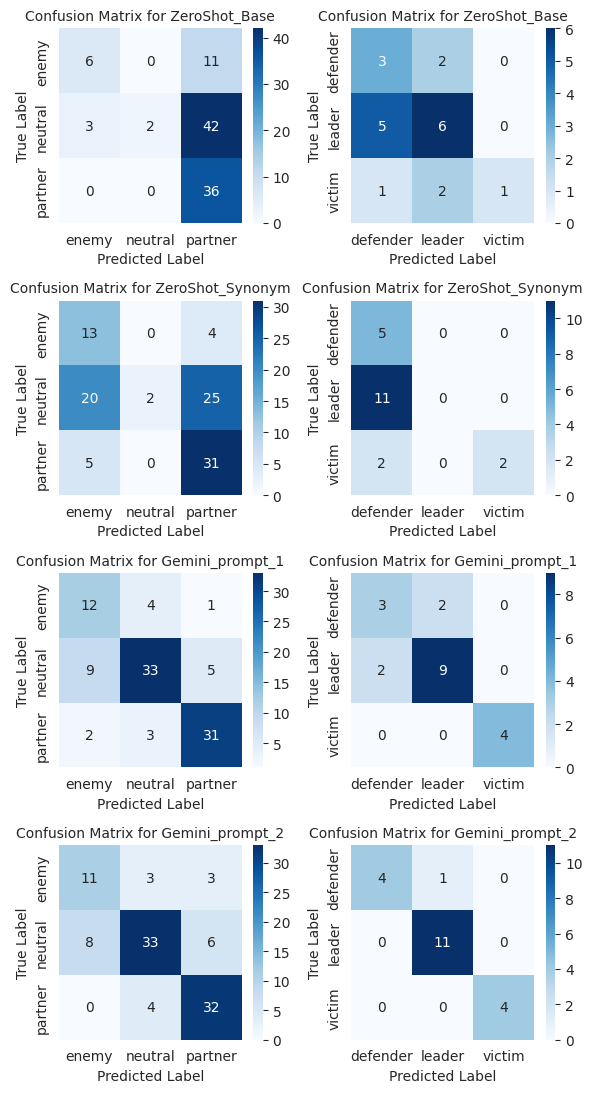

In [48]:
# Plot confusion matrices for each method
fig, axs = plt.subplots(4, 2, figsize=(6, 12))
# plt.suptitle('Confusion Matrices for Different Classification Methods', fontsize=16)

# Flatten axes for easy iteration
flat_axs = axs.flatten()

df_annotated_russia = df_annotated[df_annotated['country'] == 'Russia']
df_annotated_others = df_annotated[df_annotated['country'] != 'Russia']

for i, (col, name) in enumerate(methods_to_count):
    if col in llm_columns:
        plot_confusion_matrix(
            df_annotated_others, 
            predicted_col=col, 
            true_col='manual_classification', 
            title=f'Confusion Matrix for {name}',
            ax=flat_axs[2*i]
        )
        plot_confusion_matrix(
            df_annotated_russia, 
            predicted_col=col, 
            true_col='manual_classification', 
            title=f'Confusion Matrix for {name}',
            ax=flat_axs[2*i+1]
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# 7. Aggregating and saving classification counts

In [30]:
def aggregate_counts(df, method_col, method_name):
    """Counts occurrences of each label per country for a given method."""
    # Group by Country (found_term) and Label
    counts = df.groupby(['country', method_col]).size().reset_index(name='count')
    counts['method'] = method_name
    counts.rename(columns={method_col: 'label'}, inplace=True)
    return counts

In [31]:
# Read all sentences with classifications
all_sentences = []
for key, terms in target_terms.items():
    df_sentences = pd.read_csv(f"../data/sentences/sentences_{key}_classified.csv")
    df_sentences['country'] = key
    all_sentences.append(df_sentences)
df_sentences = pd.concat(all_sentences, ignore_index=True)

In [32]:
# List of method columns to aggregate
methods_to_count = [
    ('zs_base_label', 'ZeroShot_Base'),
    ('zs_syn_label', 'ZeroShot_Synonym')
]

In [33]:
all_counts = []

for col, name in methods_to_count:
    if col in df_sentences.columns:
        all_counts.append(aggregate_counts(df_sentences, col, name))

# Combine all into one DataFrame
if all_counts:
    df_counts = pd.concat(all_counts, ignore_index=True)
    
    # Reorder for clarity: Country, Method, Label, Count
    df_counts = df_counts[['country', 'method', 'label', 'count']]
    
    display(df_counts)
    
    # Save
    df_counts.to_csv("../data/processed/country_label_counts.csv", index=False)
else:
    print("No classification columns found to aggregate.")

,country,method,label,count
0,China,ZeroShot_Base,enemy,62
1,China,ZeroShot_Base,neutral,20
2,China,ZeroShot_Base,partner,2639
3,Poland,ZeroShot_Base,enemy,72
4,Poland,ZeroShot_Base,neutral,5
5,Poland,ZeroShot_Base,partner,284
6,Russia,ZeroShot_Base,defender,14331
7,Russia,ZeroShot_Base,leader,17320
8,Russia,ZeroShot_Base,victim,708
9,Syria,ZeroShot_Base,enemy,243


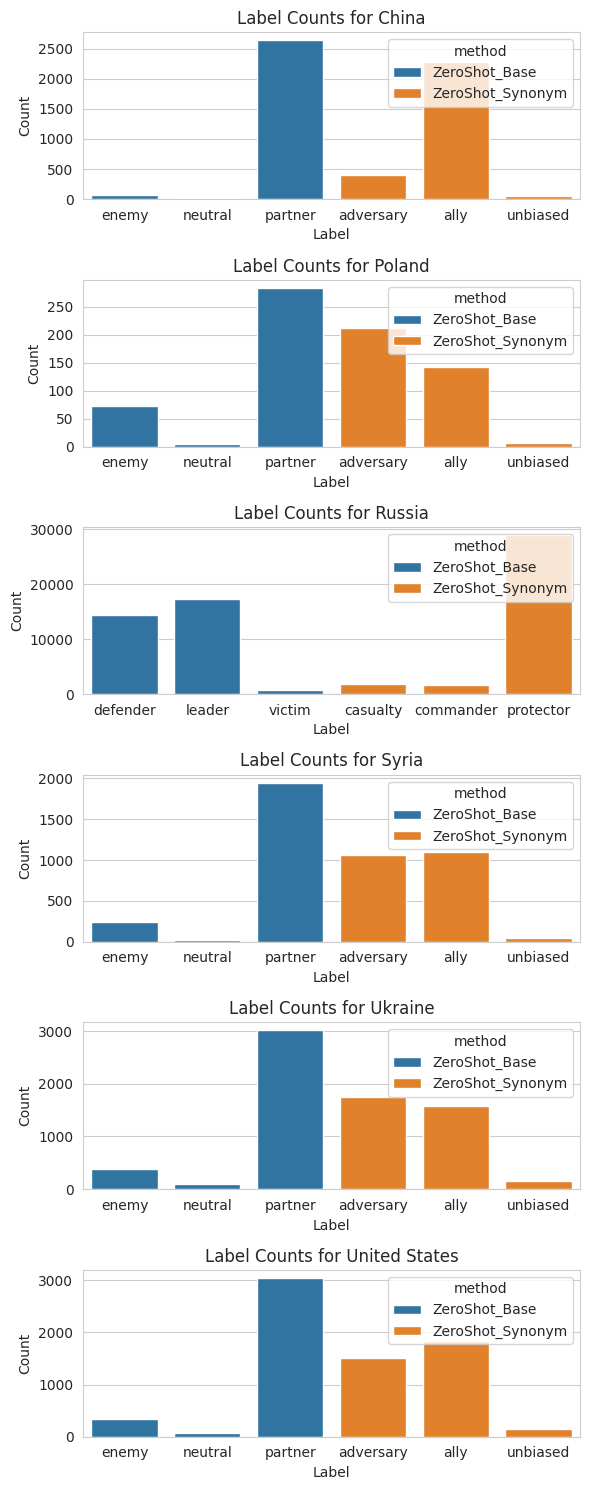

In [40]:
# Visualize counts for every country separately
countries = df_counts['country'].unique().tolist()
fig, axs = plt.subplots(6, 1, figsize=(6, 15))
for country in countries:
    df_country = df_counts[df_counts['country'] == country]
    ax = axs.flatten()[countries.index(country)]
    sns.barplot(data=df_country, x='label', y='count', hue='method', ax=ax)
    ax.set_title(f'Label Counts for {country}')
    ax.set_ylabel('Count')
    ax.set_xlabel('Label')
plt.tight_layout()
plt.show()
    